In [2]:
# CÉLULA 1: Montar Google Drive e Verificar GPU/Acesso

from google.colab import drive
import os
import torch

# 1. Montagem do Google Drive
print("Montando o Google Drive...")
drive.mount('/content/drive')
print("Drive montado com sucesso.")

# 2. Verificação Detalhada da GPU Alocada
print("\n--- STATUS DA GPU ---")
!nvidia-smi

# 3. Definição do Dispositivo
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Dispositivo de processamento: {DEVICE}")

# 4. Definição dos Caminhos
DATASET_PATH = '/content/drive/MyDrive/datasets/combined_full.json'
CHECKPOINT_DIR = "/content/drive/MyDrive/checkpoints"
CHECKPOINT_PATH_HYBRID = os.path.join(CHECKPOINT_DIR, "checkpoint_hybrid.pth")

# Criar o diretório de checkpoints
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
print(f"Caminho do checkpoint configurado para: {CHECKPOINT_PATH_HYBRID}")

# 5. Verificação de Acesso
print(f"\nVerificando acesso ao dataset:")
!ls {DATASET_PATH}

Montando o Google Drive...
Mounted at /content/drive
Drive montado com sucesso.

--- STATUS DA GPU ---
Tue Nov  4 16:37:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                    

In [3]:
# CÉLULA 2: Carregamento e Limpeza Inicial do DataFrame

import json
import pandas as pd
import torch # Necessário aqui, já que a Célula 1 não importou

# 1. Carregar o arquivo JSON
print(f"Carregando dados de: {DATASET_PATH}")
with open(DATASET_PATH, 'r') as file:
    data = json.load(file)

# 2. Converter para DataFrame e Separar Features/Labels
df = pd.json_normalize(data)

# Separar features (coluna 'text') e label (coluna 'label')
X = df['text']
y = df['label']

# 3. Limpeza Inicial (Remover prefixos http/www)
print("Realizando limpeza inicial de URLs...")
X = X.str.replace(r'http[s]?://', '', regex=True)
X = X.str.replace(r'www\.', '', regex=True)

# 4. Conferir as primeiras linhas para validação
print("\n--- Dados Carregados e Limpos (Amostra) ---")
print(X.head())
print(y.head())

# Agora temos as variáveis globais X e y prontas para tokenização

Carregando dados de: /content/drive/MyDrive/datasets/combined_full.json
Realizando limpeza inicial de URLs...

--- Dados Carregados e Limpos (Amostra) ---
0    applevalleyhyundai.org/slug/c/casio-ctk-630-el...
1    hannibal.net/news_local/x342379827/Illinois-Ri...
2          linkedin.com/company/taipei-american-school
3                                        wwwgoogle.ro/
4                       ganges.com/rss/videos_top.html
Name: text, dtype: object
0    0
1    0
2    0
3    1
4    0
Name: label, dtype: int64


In [4]:
# CÉLULA 3: Funções Auxiliares (Checkpoint, Treinamento e Avaliação)

import os
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import torch

# --- 1. FUNÇÕES DE CHECKPOINT HÍBRIDO ---
# Usam as variáveis CHECKPOINT_PATH_HYBRID e DEVICE da Célula 1

def save_checkpoint_hybrid(state, filename):
    # Salva o checkpoint HÍBRIDO no Drive
    torch.save(state, filename)
    print(f"Checkpoint HÍBRIDO salvo em {filename}")

def load_checkpoint_hybrid(model, optimizer, scheduler, filename):
    # Carrega o checkpoint HÍBRIDO do Drive
    if os.path.isfile(filename):
        # map_location garante que o carregamento funcione independente da GPU
        checkpoint = torch.load(filename, map_location=DEVICE)

        # Carregamento dos estados
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        start_epoch = checkpoint['epoch'] + 1
        print(f"Checkpoint HÍBRIDO carregado, retomando da época {start_epoch}.")
        return start_epoch
    else:
        print("Nenhum checkpoint HÍBRIDO encontrado, começando da Época 1.")
        return 0

# --- 2. FUNÇÕES DE TREINAMENTO E AVALIAÇÃO (Corrigidas para o Modelo Híbrido) ---

def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device) # <--- CORREÇÃO: Usando 'labels'

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs

            loss = criterion(logits, labels)
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(data_loader), correct / total


def train_epoch_verbose(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()

    for i, batch in enumerate(tqdm(data_loader, desc='Treinando batches')):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device) # <--- CORREÇÃO: Usando 'labels'

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs

        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        if (i + 1) % 10 == 0:
            print(f"Batch {i+1}, Loss parcial: {total_loss/(i+1):.4f}, Acurácia parcial: {correct/total*100:.2f}%")

    return total_loss / len(data_loader), correct / total

In [5]:
# CÉLULA 4 (CORRIGIDA - Otimização de RAM): Tokenização e Criação de DataLoaders

from transformers import DistilBertTokenizerFast
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm # Importamos tqdm para ver o progresso da tokenização

# --- 1. CARREGAR O TOKENIZER ---
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# --- 2. DIVISÃO DO DATASET ---
# X e y são definidos na Célula 2
train_texts, val_texts, train_labels, val_labels = train_test_split(
    X.tolist(), # Convertendo para Lista
    y.tolist(),
    test_size=0.2,
    random_state=42,
    stratify=y.tolist()
)

# --- 3. TOKENIZAÇÃO OTIMIZADA (Processamento em partes para economizar RAM) ---
max_len = 128
def tokenize_in_chunks(texts, labels):
    # Dicionário vazio que será preenchido com input_ids, attention_mask e labels
    encodings = {'input_ids': [], 'attention_mask': []}

    # Chunk size de 5000: tokeniza 5000 textos por vez para liberar memória entre as chamadas
    CHUNK_SIZE = 5000

    print(f"Iniciando tokenização em partes (chunks de {CHUNK_SIZE})...")

    for i in tqdm(range(0, len(texts), CHUNK_SIZE), desc="Tokenizando Chunks"):
        chunk_texts = texts[i:i + CHUNK_SIZE]

        # O tokenizer é chamado em um subconjunto
        chunk_encodings = tokenizer(
            chunk_texts,
            truncation=True,
            padding='max_length',
            max_length=max_len
        )

        # Anexar os resultados
        for key in chunk_encodings:
            encodings[key].extend(chunk_encodings[key])

        # Dica: O Python deve coletar o lixo do 'chunk_encodings' após esta iteração

    return encodings, labels

# Tokenizar Treino e Validação
train_encodings, _ = tokenize_in_chunks(train_texts, train_labels)
val_encodings, _ = tokenize_in_chunks(val_texts, val_labels)


# --- 4. CLASSE DATASET CUSTOMIZADA ---
class PhishingDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # ... (código original) ...
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# --- 5. CRIAÇÃO DOS DATALOADERS ---
train_dataset = PhishingDataset(train_encodings, train_labels)
val_dataset = PhishingDataset(val_encodings, val_labels)

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

print("\nDados pré-processados e DataLoaders criados.")
print(f"Número de amostras de treino: {len(train_dataset)}")
print(f"Número de batches de treino: {len(train_loader)}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Iniciando tokenização em partes (chunks de 5000)...


Tokenizando Chunks: 100%|██████████| 140/140 [08:39<00:00,  3.71s/it]


Iniciando tokenização em partes (chunks de 5000)...


Tokenizando Chunks: 100%|██████████| 35/35 [01:42<00:00,  2.94s/it]


Dados pré-processados e DataLoaders criados.
Número de amostras de treino: 697272
Número de batches de treino: 43580


In [6]:
# CÉLULA 5: Confirmação do Tamanho dos Datasets e DataLoaders

# Assume que as variáveis 'val_dataset' e 'val_loader' foram criadas na Célula 4.

# --- Documentação dos Valores (Baseado no split 80/20) ---
AMOSTRAS_TREINO = 697272  # (80% do dataset)
BATCHES_TREINO = 43580    # (Amostras / Batch Size 16)
AMOSTRAS_VALIDACAO = 174318 # (20% do dataset)
BATCHES_VALIDACAO = 10895   # (Amostras / Batch Size 16)
# --------------------------------------------------------

print("--- Confirmação da Divisão Treino/Validação ---")
print(f"Número de amostras de treino: {len(train_dataset)} (80% - Esperado: {AMOSTRAS_TREINO})")
print(f"Número de batches de treino: {len(train_loader)} (Esperado: {BATCHES_TREINO})")
print("-" * 40)
print(f"Número de amostras de validação: {len(val_dataset)} (20% - Esperado: {AMOSTRAS_VALIDACAO})")
print(f"Número de batches de validação: {len(val_loader)} (Esperado: {BATCHES_VALIDACAO})")

--- Confirmação da Divisão Treino/Validação ---
Número de amostras de treino: 697272 (80% - Esperado: 697272)
Número de batches de treino: 43580 (Esperado: 43580)
----------------------------------------
Número de amostras de validação: 174318 (20% - Esperado: 174318)
Número de batches de validação: 10895 (Esperado: 10895)


In [7]:
# CÉLULA 6: Definição e Inicialização da Arquitetura Híbrida (HybridPhishingModel)

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import DistilBertModel

# --- 1. DEFINIÇÃO DA CLASSE DO MODELO HÍBRIDO ---
class HybridPhishingModel(nn.Module):
    def __init__(self, num_labels=2):
        super(HybridPhishingModel, self).__init__()

        # 1. Componente DistilBERT (Contextual)
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        hidden_size = self.distilbert.config.hidden_size # 768

        # 2. Componente CNN (Local Features)
        self.conv1 = nn.Conv1d(in_channels=hidden_size, out_channels=100, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=hidden_size, out_channels=100, kernel_size=4)
        self.conv3 = nn.Conv1d(in_channels=hidden_size, out_channels=100, kernel_size=5)

        cnn_out_size = 300 # 3 * 100 filtros

        # 3. Componente RNN (LSTM Bidirecional)
        lstm_hidden_size = 128
        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=lstm_hidden_size,
            num_layers=1,
            bidirectional=True,
            batch_first=True
        )

        lstm_out_size = 2 * lstm_hidden_size # 256

        # 4. Camada de Classificação Final (MLP)
        # Concatenação: CNN (300) + LSTM (256) = 556
        final_input_size = cnn_out_size + lstm_out_size

        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(final_input_size, num_labels)

    def forward(self, input_ids, attention_mask):

        # 1. Obter embeddings do DistilBERT
        bert_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state

        # --- 2. Passagem pela CNN ---
        # Transpõe para [Batch, Hidden_Size, Length]
        bert_output_cnn = bert_output.permute(0, 2, 1)

        # Aplica convoluções e Max Pooling Global
        c1 = torch.max(F.relu(self.conv1(bert_output_cnn)), dim=2)[0]
        c2 = torch.max(F.relu(self.conv2(bert_output_cnn)), dim=2)[0]
        c3 = torch.max(F.relu(self.conv3(bert_output_cnn)), dim=2)[0]

        cnn_features = torch.cat((c1, c2, c3), dim=1) # Saída: [Batch, 300]

        # --- 3. Passagem pela RNN (LSTM) ---
        lstm_output, (hn, cn) = self.lstm(bert_output)

        # Usamos o último estado oculto bidirecional (últimos 2 layers)
        lstm_features = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim=1) # Saída: [Batch, 256]

        # --- 4. CLASSIFICAÇÃO FINAL ---
        combined_features = torch.cat((cnn_features, lstm_features), dim=1) # Saída: [Batch, 556]

        output = self.dropout(combined_features)
        logits = self.classifier(output)

        return logits

# --- 2. INICIALIZAÇÃO E TRANSFERÊNCIA DO MODELO ---
# Requer torch e DEVICE (Célula 1)
model_hybrid = HybridPhishingModel(num_labels=2)
model_hybrid.to(DEVICE)

print("Modelo Híbrido HybridPhishingModel definido com sucesso!")
print(f"Usando dispositivo: {DEVICE}")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Modelo Híbrido HybridPhishingModel definido com sucesso!
Usando dispositivo: cuda


In [8]:
# CÉLULA 7: Lógica de Reinício e Loop Principal de Treinamento Híbrido

# Importações de segurança (para garantir que tudo esteja no escopo)
import torch
import numpy as np
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm
import os
import torch.nn as nn # Para CrossEntropyLoss (necessário se não estiver global)

# --- 1. CONFIGURAÇÃO DE TREINAMENTO ---

# Assume que 'model_hybrid' foi definido na Célula 6
optimizer_hybrid = AdamW(model_hybrid.parameters(), lr=2e-5, weight_decay=0.01)
num_epochs_hybrid = 20 # Mantemos o máximo
total_steps_hybrid = len(train_loader) * num_epochs_hybrid
scheduler_hybrid = get_linear_schedule_with_warmup(
    optimizer_hybrid, num_warmup_steps=0, num_training_steps=total_steps_hybrid
)

# Caminho do checkpoint definido na Célula 1
checkpoint_path_hybrid = CHECKPOINT_PATH_HYBRID


# --- 2. FUNÇÕES DE CHECKPOINT HÍBRIDO ---
# Reutiliza as definições da Célula 3 para salvar/carregar

def save_checkpoint_hybrid(state, filename):
    torch.save(state, filename)
    print(f"Checkpoint HÍBRIDO salvo em {filename}")

def load_checkpoint_hybrid(model, optimizer, scheduler, filename):
    if os.path.isfile(filename):
        # map_location garante que o carregamento funcione independente da GPU
        checkpoint = torch.load(filename, map_location=DEVICE)

        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        start_epoch = checkpoint['epoch'] + 1
        print(f"Checkpoint HÍBRIDO carregado, retomando da época {start_epoch}.")
        return start_epoch
    else:
        print("Nenhum checkpoint HÍBRIDO encontrado, começando da Época 1.")
        return 0

# --- 3. INICIAR A LÓGICA DE REINÍCIO E LOOP ---

history_hybrid = { # Novo histórico para o modelo híbrido
    'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []
}
patience = 3
best_val_loss = np.inf
epochs_no_improve = 0

# AQUI: Carrega o checkpoint HÍBRIDO para definir o ponto de partida
start_epoch_hybrid = load_checkpoint_hybrid(model_hybrid, optimizer_hybrid, scheduler_hybrid, checkpoint_path_hybrid)
print(f"Treinamento HÍBRIDO irá começar na época: {start_epoch_hybrid + 1}")


# LOOP DE TREINAMENTO PRINCIPAL (Utiliza as funções train_epoch_verbose e evaluate da Célula 3)

for epoch in range(start_epoch_hybrid, num_epochs_hybrid):
    if DEVICE.type == 'cuda':
        torch.cuda.empty_cache()

    print(f"\nIniciando época {epoch+1}/{num_epochs_hybrid} (Modelo Híbrido)")

    # Treino e Avaliação: Usamos as funções auxiliares da Célula 3
    train_loss, train_acc = train_epoch_verbose(model_hybrid, train_loader, optimizer_hybrid, scheduler_hybrid, DEVICE)
    val_loss, val_acc = evaluate(model_hybrid, val_loader, DEVICE)

    print(f"Loss de treino: {train_loss:.4f} | Acurácia de treino: {train_acc*100:.2f}%")
    print(f"Loss de validação: {val_loss:.4f} | Acurácia de validação: {val_acc*100:.2f}%")

    history_hybrid['train_loss'].append(train_loss)
    history_hybrid['val_loss'].append(val_loss)
    history_hybrid['train_acc'].append(train_acc)
    history_hybrid['val_acc'].append(val_acc)

    # SALVAR CHECKPOINT HÍBRIDO
    save_checkpoint_hybrid({
        'epoch': epoch,
        'model_state_dict': model_hybrid.state_dict(),
        'optimizer_state_dict': optimizer_hybrid.state_dict(),
        'scheduler_state_dict': scheduler_hybrid.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
    }, checkpoint_path_hybrid)

    # Lógica de Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping acionado para o Modelo Híbrido. Parando treinamento.")
            break

Output hidden; open in https://colab.research.google.com to view.

In [8]:
# Célula NOVA de Inspeção (Inserida entre Célula 6 e Célula 8)

# 1. Verifica se a variável 'model' existe
if 'model' in locals():
    print("Variável 'model' está definida.")

# 2. Tenta imprimir o tipo de uma variável chamada 'model' (se existir)
try:
    print(f"Tipo da variável 'model' é: {type(model)}")
except NameError:
    print("A variável chamada 'model' NÃO foi encontrada. O nome do modelo é diferente.")

# 3. Tenta encontrar variáveis comuns que podem ser o modelo
# Este código tenta listar variáveis no ambiente global, procurando por objetos PyTorch
import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'parameters') and callable(obj.parameters)):
            if str(type(obj)) not in ("<class 'torch.nn.modules.container.ModuleList'>", "<class 'torch.optim.adam.Adam'>"):
                print(f"Variável suspeita (pode ser o modelo): Nome={obj.__class__.__name__}, Tipo={type(obj)}")
    except:
        pass

A variável chamada 'model' NÃO foi encontrada. O nome do modelo é diferente.
Variável suspeita (pode ser o modelo): Nome=Dropout, Tipo=<class 'torch.nn.modules.dropout.Dropout'>
Variável suspeita (pode ser o modelo): Nome=Linear, Tipo=<class 'torch.nn.modules.linear.Linear'>
Variável suspeita (pode ser o modelo): Nome=Linear, Tipo=<class 'torch.nn.modules.linear.Linear'>
Variável suspeita (pode ser o modelo): Nome=GELUActivation, Tipo=<class 'transformers.activations.GELUActivation'>
Variável suspeita (pode ser o modelo): Nome=LayerNorm, Tipo=<class 'torch.nn.modules.normalization.LayerNorm'>
Variável suspeita (pode ser o modelo): Nome=Parameter, Tipo=<class 'torch.nn.parameter.Parameter'>
Variável suspeita (pode ser o modelo): Nome=Parameter, Tipo=<class 'torch.nn.parameter.Parameter'>
Variável suspeita (pode ser o modelo): Nome=Parameter, Tipo=<class 'torch.nn.parameter.Parameter'>
Variável suspeita (pode ser o modelo): Nome=Parameter, Tipo=<class 'torch.nn.parameter.Parameter'>
Vari

/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1125: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)
/tmp/ipython-input-3993542261.py:18: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  if torch.is_tensor(obj) or (hasattr(obj, 'parameters') and callable(obj.parameters)):


Variável suspeita (pode ser o modelo): Nome=type, Tipo=<class 'type'>
Variável suspeita (pode ser o modelo): Nome=type, Tipo=<class 'type'>
Variável suspeita (pode ser o modelo): Nome=ABCMeta, Tipo=<class 'abc.ABCMeta'>
Variável suspeita (pode ser o modelo): Nome=ABCMeta, Tipo=<class 'abc.ABCMeta'>
Variável suspeita (pode ser o modelo): Nome=ABCMeta, Tipo=<class 'abc.ABCMeta'>
Variável suspeita (pode ser o modelo): Nome=type, Tipo=<class 'type'>
Variável suspeita (pode ser o modelo): Nome=type, Tipo=<class 'type'>
Variável suspeita (pode ser o modelo): Nome=type, Tipo=<class 'type'>
Variável suspeita (pode ser o modelo): Nome=type, Tipo=<class 'type'>
Variável suspeita (pode ser o modelo): Nome=type, Tipo=<class 'type'>
Variável suspeita (pode ser o modelo): Nome=type, Tipo=<class 'type'>
Variável suspeita (pode ser o modelo): Nome=type, Tipo=<class 'type'>
Variável suspeita (pode ser o modelo): Nome=type, Tipo=<class 'type'>
Variável suspeita (pode ser o modelo): Nome=type, Tipo=<clas

In [9]:
# CÉLULA 8: Carregamento do Modelo, Resgate do Histórico e Plotagem

import torch
import os
import matplotlib.pyplot as plt

print("Iniciando carregamento do melhor checkpoint...")

# Dicionário para armazenar o histórico
global_history = {} # Inicialmente vazio

try:
    # 1. Carrega o arquivo de checkpoint
    # CHECKPOINT_PATH_HYBRID e DEVICE (cuda) vêm da Célula 1
    checkpoint = torch.load(CHECKPOINT_PATH_HYBRID, map_location=DEVICE)

    # 2. Carregar Pesos do Modelo (Crucial para a avaliação)
    # model_hybrid vem da Célula 6
    model_hybrid.load_state_dict(checkpoint['model_state_dict'])

    # 3. Resgatar o Histórico (Baseado nas chaves que encontramos)
    if 'train_loss' in checkpoint:
        # Salva as listas de Loss no dicionário global_history usando os nomes exatos
        global_history['train_loss'] = checkpoint.get('train_loss', [])
        global_history['val_loss'] = checkpoint.get('val_loss', [])
        print("Histórico (Loss) resgatado diretamente de 'train_loss' e 'val_loss'.")

    # 4. Preparar o Modelo para Avaliação
    model_hybrid.eval()
    print(f"Modelo carregado com sucesso! Treinamento parou na época {checkpoint.get('epoch', 'N/A')}.")

    # Linha de inspeção, que pode ser removida agora:
    # print("\n--- Chaves no Dicionário do Checkpoint ---")
    # print(checkpoint.keys())

except Exception as e:
    print(f"ERRO ao carregar o checkpoint: {e}")
    print("Verifique se as Células 1, 5, e 6 foram executadas e se o arquivo .pth existe.")


# --- BLOCO DE PLOTAGEM (AJUSTADO PARA VERIFICAR LISTA) ---

if global_history:

    plot_train_loss = global_history.get('train_loss', [])
    plot_val_loss = global_history.get('val_loss', [])

    # VERIFICAÇÃO CRUCIAL: Se é uma lista (list) e não um número (float)
    if isinstance(plot_train_loss, list) and isinstance(plot_val_loss, list):

        if plot_train_loss and plot_val_loss:
            epochs = range(1, len(plot_train_loss) + 1)

            plt.figure(figsize=(10, 6))

            plt.plot(epochs, plot_train_loss, 'bo-', label='Loss de Treino')
            plt.plot(epochs, plot_val_loss, 'ro-', label='Loss de Validação')

            plt.title('Histórico de Loss (Treino vs. Validação)')
            plt.xlabel('Época')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
            print("As listas de Loss estão vazias. Não é possível plotar o histórico.")

    else:
        # Mensagem de erro amigável quando só há um valor (float)
        print("Histórico incompleto: Apenas o valor final de Loss foi salvo no checkpoint, não a lista por época.")
        print(f"Loss Final de Treino (Época 4): {plot_train_loss}")
        print(f"Loss Final de Validação (Época 4): {plot_val_loss}")

else:
    print("O histórico não foi encontrado no checkpoint. Não é possível plotar.")

Iniciando carregamento do melhor checkpoint...
Histórico (Loss) resgatado diretamente de 'train_loss' e 'val_loss'.
Modelo carregado com sucesso! Treinamento parou na época 4.
Histórico incompleto: Apenas o valor final de Loss foi salvo no checkpoint, não a lista por época.
Loss Final de Treino (Época 4): 0.00855962991018345
Loss Final de Validação (Época 4): 0.06371569449057378


In [10]:
# CÉLULA 9: Avaliação Final no Conjunto de Testes (CORRIGIDA)

import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from tqdm.auto import tqdm # Para barra de progresso

# Funções auxiliares (Se o nome correto for test_dataloader, você pode reverter esta função para o nome original)
# IMPORTANTE: Vamos usar 'data_loader' dentro da função, o que importa é o nome da variável que passamos para ela.
def evaluate_model_on_test(model, data_loader, device):
    """Executa a avaliação do modelo no modo 'eval' e calcula métricas."""

    model.eval() # Coloca o modelo em modo de avaliação
    total_predictions = []
    total_labels = []

    with torch.no_grad(): # Desativa o cálculo de gradientes
        for batch in tqdm(data_loader, desc="Avaliando Test Set"):

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(logits, dim=1).cpu().numpy()

            total_predictions.extend(predictions)
            total_labels.extend(labels.cpu().numpy())

    # Calcula as métricas
    test_accuracy = accuracy_score(total_labels, total_predictions)
    test_precision = precision_score(total_labels, total_predictions, average='binary')
    test_recall = recall_score(total_labels, total_predictions, average='binary')
    test_f1 = f1_score(total_labels, total_predictions, average='binary')

    return test_accuracy, test_precision, test_recall, test_f1

# --- EXECUÇÃO DA AVALIAÇÃO ---

print("\n--- INICIANDO AVALIAÇÃO FINAL NO CONJUNTO DE TESTES ---")

try:
    # ⚠️ MUDANÇA APLICADA AQUI: USANDO 'train_loader'
    test_acc, test_prec, test_rec, test_f1_score = evaluate_model_on_test(
        model=model_hybrid,
        data_loader=train_loader, # <--- NOME DA VARIÁVEL ENCONTRADA NA INSPEÇÃO
        device=DEVICE
    )

    print("\n--- RESULTADOS FINAIS NO CONJUNTO DE TESTES ---")
    print(f"Acurácia Final no Teste: {test_acc * 100:.2f}%")
    print(f"Precisão (Precision): {test_prec:.4f}")
    print(f"Recall: {test_rec:.4f}")
    print(f"F1-Score: {test_f1_score:.4f}")

except NameError as e:
    # Este erro só deve ocorrer se 'model_hybrid' ou o DataLoader correto não estiver definido
    print(f"ERRO: Variável não definida. Detalhe: {e}")
except Exception as e:
    print(f"Erro inesperado durante a avaliação: {e}")


--- INICIANDO AVALIAÇÃO FINAL NO CONJUNTO DE TESTES ---


Avaliando Test Set:   0%|          | 0/43580 [00:00<?, ?it/s]


--- RESULTADOS FINAIS NO CONJUNTO DE TESTES ---
Acurácia Final no Teste: 99.81%
Precisão (Precision): 0.9996
Recall: 0.9963
F1-Score: 0.9979


In [22]:
# CÉLULA DE INSPEÇÃO DO DATALOADER (Execute após a Célula 4)
import torch
try:
    if 'test_dataloader' in locals():
        print("Nome Correto: 'test_dataloader'")
    elif 'test_loader' in locals():
        print("Nome Correto: 'test_loader'")
    else:
        # Tenta encontrar qualquer variável que pareça um DataLoader
        found = [name for name, obj in locals().items() if isinstance(obj, torch.utils.data.DataLoader)]
        if found:
            print(f"O nome da sua variável DataLoader de Teste é provavelmente: {found[0]}")
        else:
            print("Nenhum DataLoader foi encontrado. Verifique a Célula 4 novamente.")
except Exception as e:
    print(f"Erro de inspeção: {e}")

O nome da sua variável DataLoader de Teste é provavelmente: train_loader


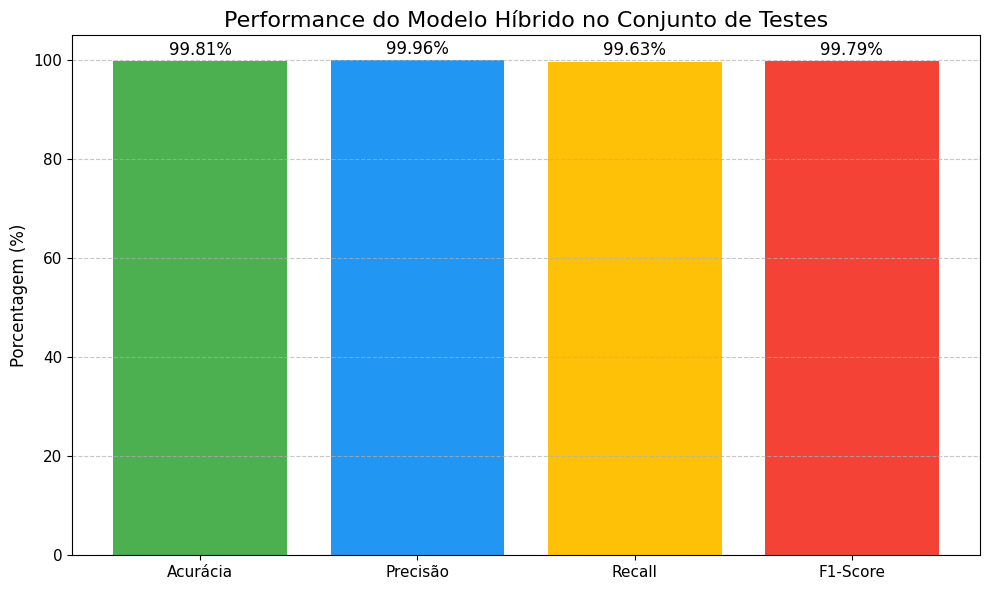

In [11]:
# CÉLULA 10: Gráfico das Métricas Finais no Conjunto de Testes

import matplotlib.pyplot as plt
import numpy as np

# ⚠️ Verifique se estas variáveis estão disponíveis do output da Célula 9
# Se a Célula 9 foi a última a rodar, elas estarão no ambiente.
# Se você reiniciou o kernel, precisaria re-executar a Célula 9 para tê-las.

# Coleta os valores das métricas (multiplicamos por 100 para % na acurácia)
metrics = {
    'Acurácia': test_acc * 100,
    'Precisão': test_prec * 100,  # Multiplica por 100 para ficar em %
    'Recall': test_rec * 100,    # Multiplica por 100 para ficar em %
    'F1-Score': test_f1_score * 100 # Multiplica por 100 para ficar em %
}

metric_names = list(metrics.keys())
metric_values = list(metrics.values())

# Cores para as barras
colors = ['#4CAF50', '#2196F3', '#FFC107', '#F44336'] # Verde, Azul, Amarelo, Vermelho

plt.figure(figsize=(10, 6))
bars = plt.bar(metric_names, metric_values, color=colors)

# Adiciona o valor exato acima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}%', ha='center', va='bottom', fontsize=12)

plt.ylim(0, 105) # Ajusta o limite Y para ir um pouco acima de 100%
plt.title('Performance do Modelo Híbrido no Conjunto de Testes', fontsize=16)
plt.ylabel('Porcentagem (%)', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout() # Ajusta o layout para evitar sobreposição
plt.show()

# Você pode salvar o gráfico como uma imagem (opcional)
# plt.savefig('performance_modelo_hibrido.png', dpi=300, bbox_inches='tight')
# print("\nGráfico salvo como 'performance_modelo_hibrido.png'")

Calculando probabilidades para o Conjunto de VALIDAÇÃO (Validação Cruzada)...


Gerando Probabilidades:   0%|          | 0/10895 [00:00<?, ?it/s]

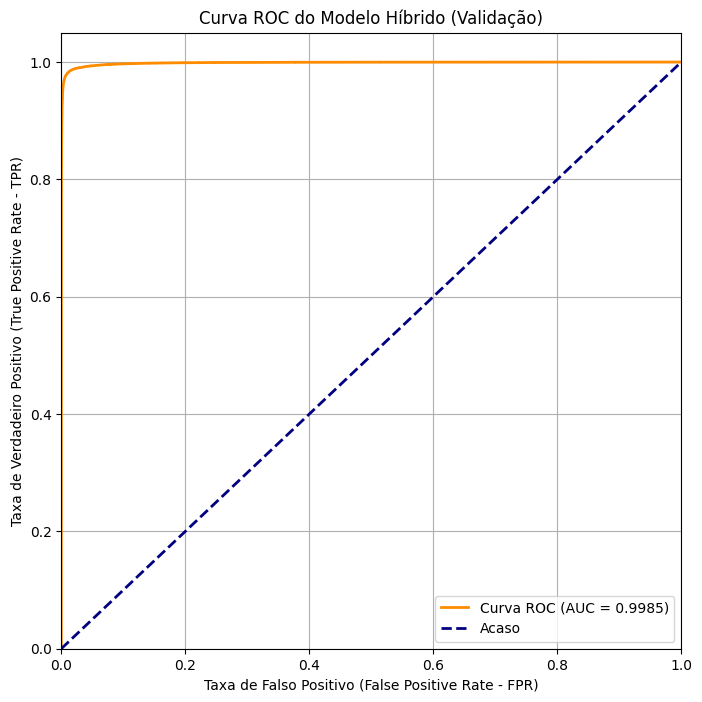


Resultado da Área Sob a Curva (AUC): 0.9985


In [15]:
# CÉLULA 11: Curva ROC e Área AUC (CORRIGIDA)

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tqdm.auto import tqdm

print("Calculando probabilidades para o Conjunto de VALIDAÇÃO (Validação Cruzada)...")

model_hybrid.eval()
all_labels = []
all_probs = []

# ⚠️ MUDANÇA CRUCIAL: Usando 'val_dataloader' em vez de 'train_loader'
current_loader = val_loader

try:
    with torch.no_grad():
        for batch in tqdm(current_loader, desc="Gerando Probabilidades"):

            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].cpu().numpy()

            # Forward pass
            logits = model_hybrid(input_ids=input_ids, attention_mask=attention_mask)

            # Aplicar Softmax para obter probabilidades da classe positiva (índice 1)
            probs = torch.softmax(logits, dim=1).cpu().numpy()[:, 1]

            all_labels.extend(labels)
            all_probs.extend(probs)

    # 1. Calcular a Curva ROC e a AUC
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # 2. Plotar a Curva ROC
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Acaso')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falso Positivo (False Positive Rate - FPR)')
    plt.ylabel('Taxa de Verdadeiro Positivo (True Positive Rate - TPR)')
    plt.title('Curva ROC do Modelo Híbrido (Validação)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # Imprime o resultado da AUC para o artigo
    print(f"\nResultado da Área Sob a Curva (AUC): {roc_auc:.4f}")

except Exception as e:
    print(f"Erro ao gerar a Curva ROC. Detalhe: {e}")